# Classic vs Modern Bus Types in Panama City

This deep learning model is the result of the assigment for lesson 1 of the [fastai course](http://course.fast.ai/) for Fall 2018. It was built using the fastai ai library, which sits on top of [Pytorch v1](https://pytorch.org/). The GPU used was an NVIDIA P4 GPU with 8 CPU's and 52 GB of RAM run from the Google Cloud Platform [(GCP)](https://cloud.google.com/gpu/)

In this lesson we will build our first image classifier from scratch. The classifier will try to determine if an image is a classic Panamian bus called *Diablo Rojo* or the modern type called *Metrobus*.  Let's dive in!

The following three lines ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [43]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [44]:
from fastai import *
from fastai.vision import *

## Looking at the data

For the model, we downloaded 100 images from Google of each class and split them into 3 folders: test, valid, and train.  After removing mislabeled images we ended up with 56 images in the training set and 28 images in the validadtion set for each class.  The test set was not used to verify this model.

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('data/buses.zip', 'r')
zip_ref.extractall('data/')
zip_ref.close()

In [ ]:
path = Path('data/buses/')

In [6]:
path.ls()

['test', 'valid', 'train']

In [13]:
(path/'train').ls()

['bus diablo rojo panama', 'bus metrobus panama']

In [9]:
path_img = path/'train/bus diablo rojo panama'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

Fortunately we are classifying images the easy way. We put each image class into their respective folders and use the command **ImageDataBunch.from_folder** to create the dataset.

In [10]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('data/buses/train/bus diablo rojo panama/bus diablo rojo panama 31. ciudad-de-panama.jpg'),
 PosixPath('data/buses/train/bus diablo rojo panama/bus diablo rojo panama 92. panama_bus.jpg'),
 PosixPath('data/buses/train/bus diablo rojo panama/bus diablo rojo panama 35. maxresdefault.jpg'),
 PosixPath('data/buses/train/bus diablo rojo panama/bus diablo rojo panama 39. nico-and-andres-from.jpg'),
 PosixPath('data/buses/train/bus diablo rojo panama/bus diablo rojo panama 56. p1120319.jpg')]

In [19]:
tfms = get_transforms(do_flip=False)

In [20]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=224)
data.normalize(imagenet_stats)

Now that a [DataBunch](https://docs.fast.ai/basic_data.html) named "data" has been created, we can use the show_batch command to look at the images

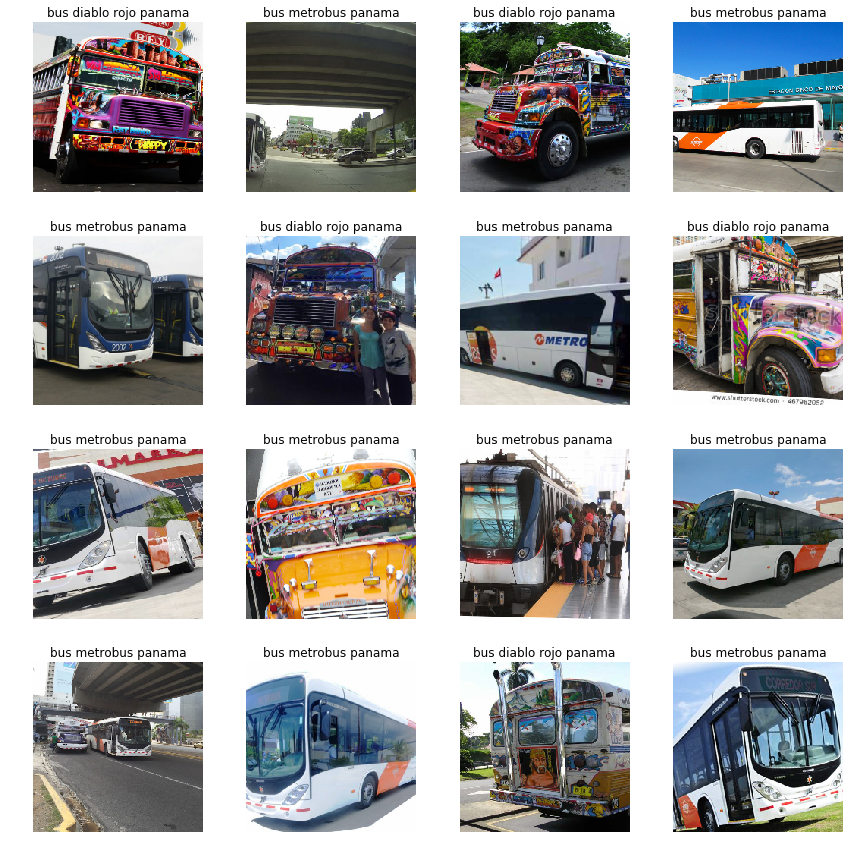

In [22]:
data.show_batch(rows=4, figsize=(12,12))

In [ ]:
print(data.classes)
len(data.classes)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. We are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 2 outputs).

We will train for 5 epochs (5 cycles through all our data).

In [26]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [28]:
learn.fit_one_cycle(5)

Total time: 00:38
epoch  train_loss  valid_loss  error_rate
1      0.047055    0.191808    0.035714    (00:08)
2      0.052807    0.217153    0.035714    (00:07)
3      0.050738    0.221998    0.035714    (00:07)
4      0.041403    0.212529    0.017857    (00:08)
5      0.043284    0.207209    0.017857    (00:07)



In [38]:
learn.save('stage-1')

This commando saves the model at this stage.  The result after 4 cyciles is 98.2%

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

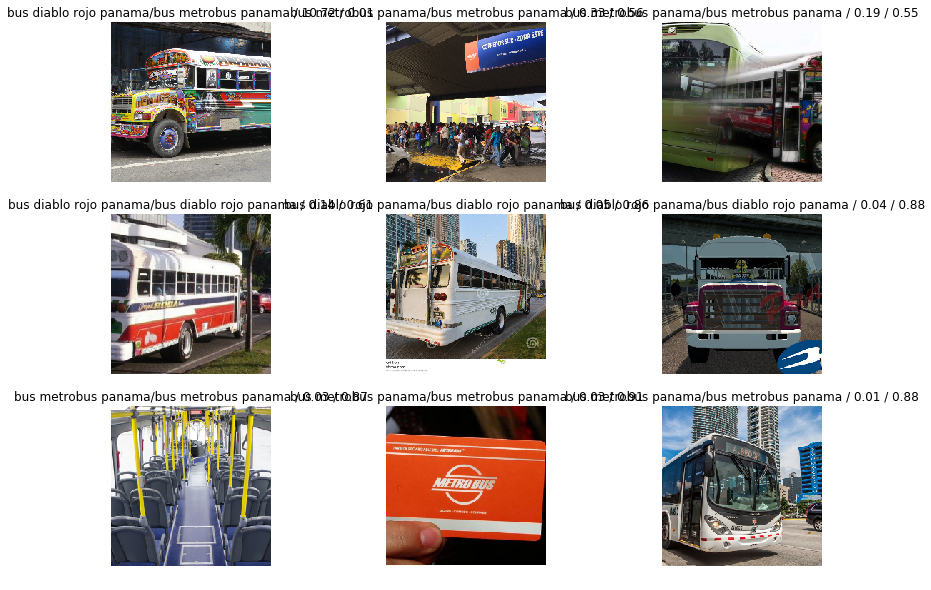

In [33]:
interp.plot_top_losses(9, figsize=(14,10))

Furthermore, when we plot the confusion matrix, we can see that the model only had 1 mistake. The model predicted a *Diablo Rojo* where it was actually a *Metrobus*

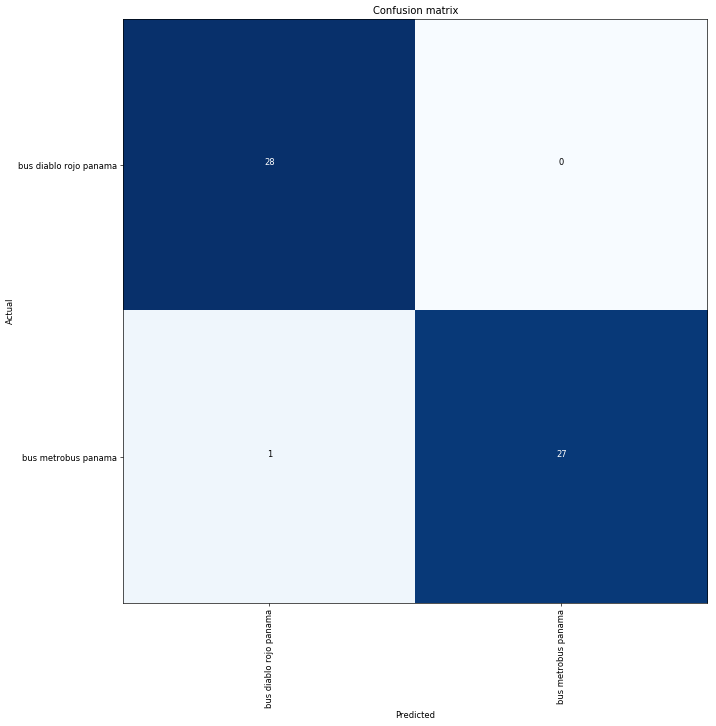

In [34]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more. The first model was run with the first layers frozen.

In [36]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

In [39]:
learn.load('stage-1')

In [40]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


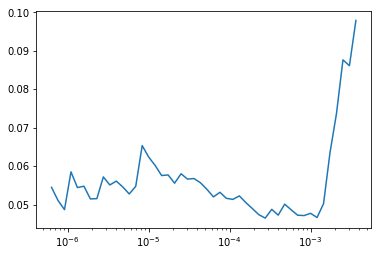

In [41]:
learn.recorder.plot()

From the plot of error vs learning rate it can be seen that the error is at it lowest points between 10^-6 and 10^-3.  So we will fit the model again with the learning using those numbers

In [42]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

Total time: 00:17
epoch  train_loss  valid_loss  error_rate
1      0.098510    0.189597    0.017857    (00:08)
2      0.064295    0.194010    0.017857    (00:08)



That's a pretty accurate model!  It's 98.2%.